## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on MNIST data, a classification task.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

2024-03-24 15:17:16.002287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The MNIST Data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Train a Model with Gradient Loss

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [4]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        gradient_loss = gradient_loss_fn(x, y)
    grads = tape.gradient(gradient_loss.loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return gradient_loss.loss

In [5]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [6]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(100)

In [7]:
for epoch in range(20):
    for x, y in ds:
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

0 0.014690099 0.9356
1 0.014000436 0.9561
2 0.013636587 0.9626
3 0.013400788 0.9685
4 0.013778207 0.9609
5 0.013410813 0.9638
6 0.013627361 0.9701
7 0.013661625 0.9721
8 0.013682258 0.9733
9 0.013484694 0.9729
10 0.013661419 0.9724
11 0.013379583 0.9752
12 0.013375832 0.9715
13 0.013377672 0.9714
14 0.013394096 0.9707
15 0.013375449 0.9757
16 0.01338369 0.9753
17 0.01337144 0.9716
18 0.013372241 0.9767
19 0.01338826 0.9778


In [8]:
evaluate(model)

0.9778

## Baseline Model with Usual Loss

In [9]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

In [10]:
baseline_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [11]:
baseline_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/20
1875/1875 - 2s - loss: 0.2281 - accuracy: 0.9330 - val_loss: 0.1221 - val_accuracy: 0.9641 - 2s/epoch - 1ms/step
Epoch 2/20
1875/1875 - 2s - loss: 0.0964 - accuracy: 0.9704 - val_loss: 0.1199 - val_accuracy: 0.9631 - 2s/epoch - 930us/step
Epoch 3/20
1875/1875 - 2s - loss: 0.0675 - accuracy: 0.9790 - val_loss: 0.0786 - val_accuracy: 0.9757 - 2s/epoch - 941us/step
Epoch 4/20
1875/1875 - 2s - loss: 0.0506 - accuracy: 0.9837 - val_loss: 0.0853 - val_accuracy: 0.9752 - 2s/epoch - 937us/step
Epoch 5/20
1875/1875 - 2s - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.0819 - val_accuracy: 0.9762 - 2s/epoch - 938us/step
Epoch 6/20
1875/1875 - 2s - loss: 0.0326 - accuracy: 0.9889 - val_loss: 0.0805 - val_accuracy: 0.9770 - 2s/epoch - 962us/step
Epoch 7/20
1875/1875 - 2s - loss: 0.0265 - accuracy: 0.9913 - val_loss: 0.0773 - val_accuracy: 0.9790 - 2s/epoch - 935us/step
Epoch 8/20
1875/1875 - 2s - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0930 - val_accuracy: 0.9749 - 2s/epoch - 936us

In [12]:
evaluate(baseline_model)

0.9794

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [16]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 50)):
    stddevs.append(stddev)
    # x_test_noised = x_test + tf.random.norm(tf.shape(x_test)) * stddev
    x_test_noised = x_test + tf.random.uniform(tf.shape(x_test), -1., 1.) * stddev
    x_test_noised = tf.clip_by_value(x_test_noised, 0., 1.)
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.19it/s]


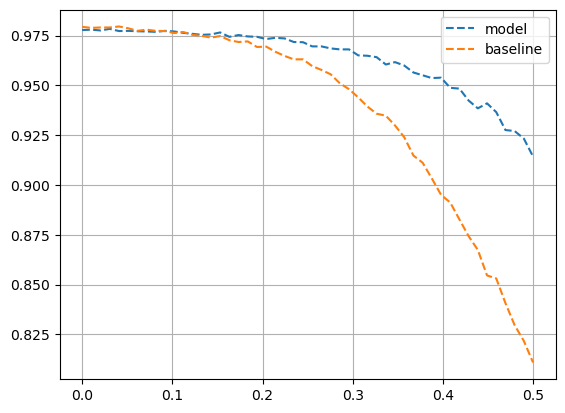

In [17]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## MNIST-C

In this section, we are to exame the model and the baseline model on the [MNIST-C](https://github.com/google-research/mnist-c) dataset, which was designed for evaluating the robustness of models trained on MNIST dataset.

We have downloaded the ZIP file from [here](https://zenodo.org/records/3239543), and unpacked into the `data` folder.

In [20]:
print('noise type : model accuracy : baseline accuracy : exceed')
for noise_type in os.listdir('data/mnist_c'):
    x_eval = np.load(f'data/mnist_c/{noise_type}/test_images.npy')
    y_eval = np.load(f'data/mnist_c/{noise_type}/test_labels.npy')
    
    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0
    y_eval = y_eval.astype('float32')

    model_eval = accuracy_score(y_eval, tf.argmax(model(x_eval), axis=1))
    baseline_eval = accuracy_score(y_eval, tf.argmax(baseline_model(x_eval), axis=1))
    exceed = model_eval - baseline_eval
    
    print(f'{noise_type} : {model_eval} : {baseline_eval} : {exceed*100:.1f}%')

noise type : model accuracy : baseline accuracy : exceed
dotted_line : 0.9543 : 0.9174 : 3.7%
stripe : 0.3959 : 0.2285 : 16.7%
shot_noise : 0.9688 : 0.9685 : 0.0%
rotate : 0.8424 : 0.8546 : -1.2%
motion_blur : 0.8242 : 0.8556 : -3.1%
impulse_noise : 0.9278 : 0.8218 : 10.6%
spatter : 0.9551 : 0.9322 : 2.3%
canny_edges : 0.682 : 0.6585 : 2.4%
zigzag : 0.8345 : 0.7218 : 11.3%
glass_blur : 0.9468 : 0.9286 : 1.8%
brightness : 0.3056 : 0.2913 : 1.4%
scale : 0.6808 : 0.7009 : -2.0%
fog : 0.2202 : 0.2404 : -2.0%
identity : 0.9778 : 0.9794 : -0.2%
translate : 0.2863 : 0.3164 : -3.0%
shear : 0.9414 : 0.9366 : 0.5%


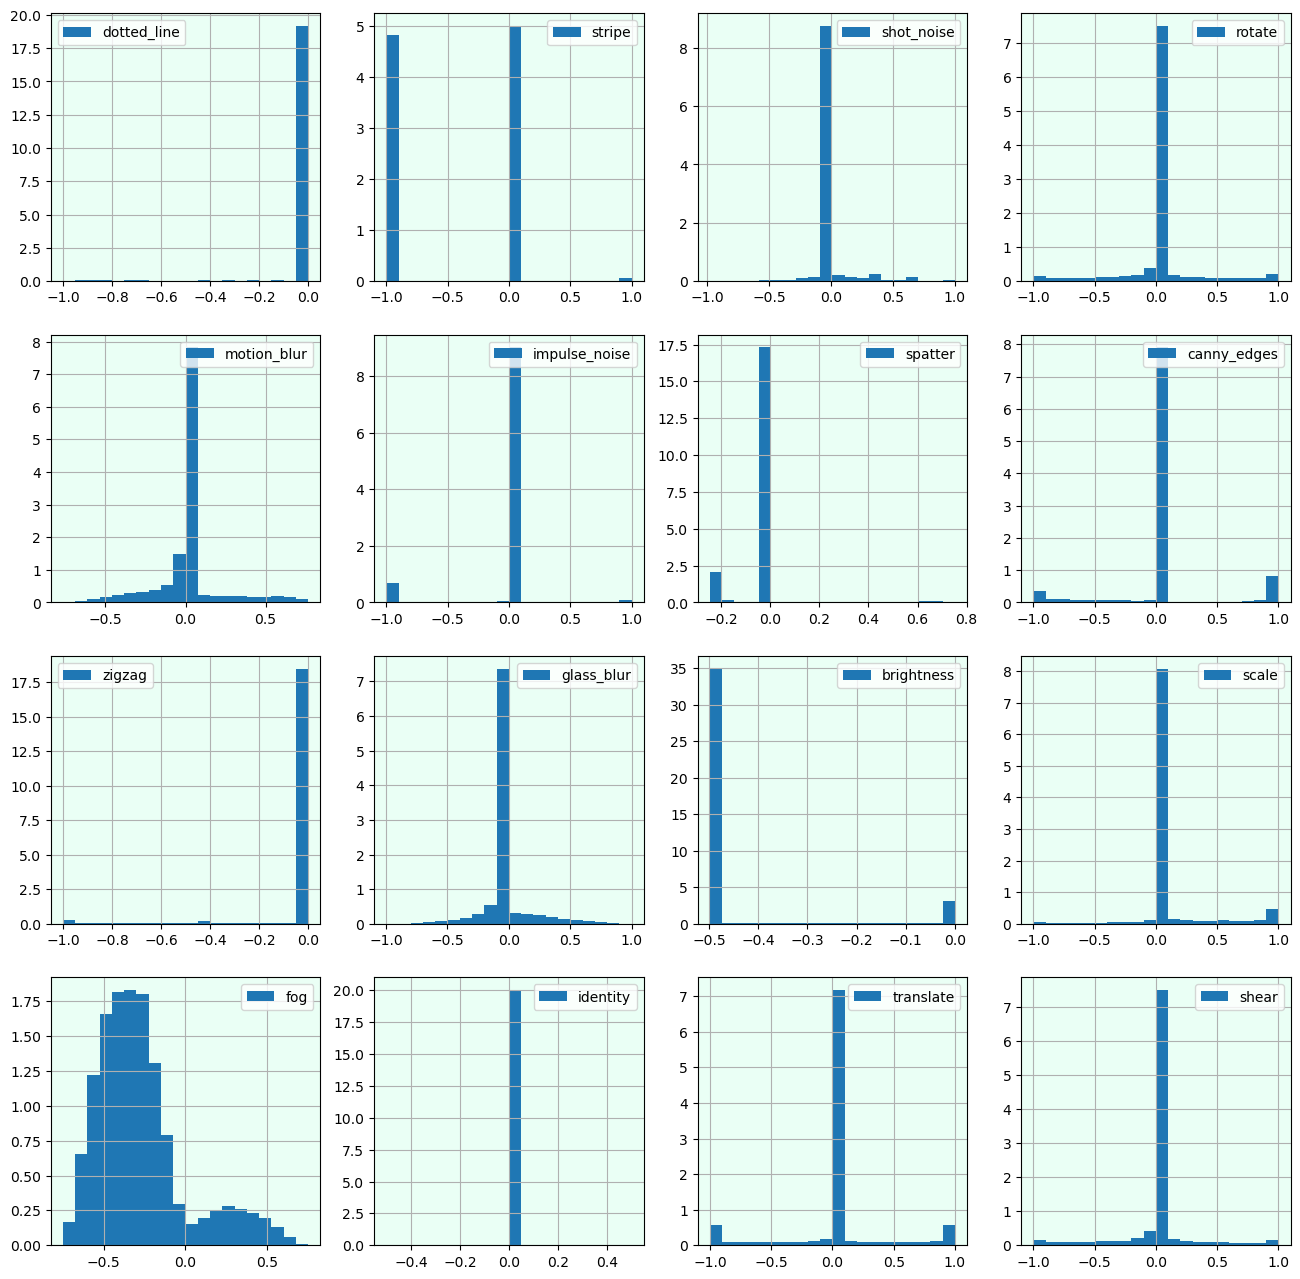

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, noise_type in enumerate(os.listdir('data/mnist_c')):
    j = i // 4
    k = i % 4
    ax = axs[j][k]

    x_eval = np.load(f'data/mnist_c/{noise_type}/test_images.npy')
    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0

    diff = (x_test - x_eval).reshape([-1])
    ax.hist(diff, 20, label=noise_type, density=True)
    ax.legend()
    ax.grid()
    ax.set_facecolor('#eafff5')

plt.show()

## Conclusion

- We have trained a simple feed-forward neural network on the MNIST dataset by minimizing loss gradients.
- The performance examed by accuracy approaches the baseline, which is trained by minimizing loss.
- For simple Gaussian noise, the robustness is greatly out-performs the baseline.
- We also examed more types of noise, using the MNIST-C dataset. We find that the robustness is significant on the types "dotted line" and "inpulse noise". Temporally, there is no hint about when robustness out-performs the baseline.